<div style="text-align: right">   </div>


Introduction to Deep Learning (2024) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Sequence processing using RNNs** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction
The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.

# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [47]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
import pandas as pd

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell, MaxPooling2D, BatchNormalization, Dropout,LayerNormalization, Attention
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.keras.layers import  Add,RepeatVector,Conv2DTranspose
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.layers import Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam


# Print TensorFlow version and check GPU availability
print("TensorFlow version:", tf.__version__)
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING logs

TensorFlow version: 2.17.1
Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


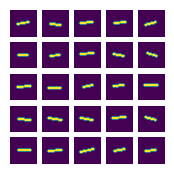

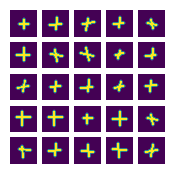

In [2]:
from scipy.ndimage import rotate

# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [3]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """
    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

In [4]:
unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)

## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

# for _ in range(10):
#     display_sample(np.random.randint(0, 10000, 1)[0])

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)


## Helper functions

The functions below will help with input/output of the data.

In [5]:
# One-hot encoding/decoding for the text queries/answers 
def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)
print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

In [6]:
def sequence_accuracy(y_true, y_pred):
    y_true_decoded = tf.argmax(y_true, axis=-1)
    y_pred_decoded = tf.argmax(y_pred, axis=-1)
    matches = tf.reduce_all(tf.equal(y_true_decoded, y_pred_decoded), axis=1)
    return tf.reduce_mean(tf.cast(matches, tf.float32))

In [7]:
def build_text2text_model():
    """
    Build a text-to-text RNN model for sequence-to-sequence learning.
    """
    # Initialize a sequential model
    text2text = tf.keras.Sequential()

    # Encoder: Use LSTM to encode the input sequence
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # Repeat the encoded output to match the maximum output length
    text2text.add(RepeatVector(max_answer_length))

    # Decoder: Use LSTM to decode the repeated vector into a sequence
    text2text.add(LSTM(256, return_sequences=True))

    # Output layer: Apply TimeDistributed Dense layer to predict each character in the sequence
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Compile the model with additional metrics, including sequence_accuracy
    text2text.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', sequence_accuracy]
    )

    text2text.summary()
    return text2text

def build_improved_text2text_model():
    """
    Build an enhanced text-to-text RNN model with attention and additional regularization.
    """
    inputs = Input(shape=(max_query_length, len(unique_characters)))

    # Encoder
    encoder_lstm = LSTM(512, return_sequences=True)(inputs)
    encoder_lstm = Dropout(0.3)(encoder_lstm)  # Dropout for regularization
    encoder_lstm = LayerNormalization()(encoder_lstm)
    encoder_lstm = LSTM(512, return_sequences=True)(encoder_lstm)
    encoder_lstm = Dropout(0.3)(encoder_lstm)
    encoder_lstm = LayerNormalization()(encoder_lstm)

    # Attention Mechanism
    attention_output = Attention()([encoder_lstm, encoder_lstm])

    # Decoder
    decoder_lstm = LSTM(512, return_sequences=False)(attention_output)
    decoder_repeat = RepeatVector(max_answer_length)(decoder_lstm)
    decoder_lstm = LSTM(512, return_sequences=True)(decoder_repeat)
    decoder_lstm = Dropout(0.3)(decoder_lstm)
    decoder_lstm = LayerNormalization()(decoder_lstm)

    # Output Layer
    outputs = TimeDistributed(Dense(len(unique_characters), activation='softmax'))(decoder_lstm)

    # Model Compilation
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', sequence_accuracy]
    )
    return model

In [8]:
# Reduce the learning rate after 10 epochs
def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.5
    return lr

In [9]:
def evaluate_datasets_with_splits(model_builder, X, y, split_ratios, epochs=10, batch_size=64):
    results = []
    for split_ratio in split_ratios:
        # Split the dataset
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=1 - split_ratio, random_state=42
        )
        print(f"\nTraining with {int(split_ratio * 100)}% Train / {int((1 - split_ratio) * 100)}% Test Split")

        # Define callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Stops training early if no improvement
            LearningRateScheduler(lr_schedule)  # Dynamically adjusts learning rate
        ]

        # Build and train the model
        model = model_builder()
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,  # Use the updated callbacks here
            verbose=1
        )

        # Evaluate on the test set
        test_loss, test_accuracy, test_seq_accuracy = model.evaluate(X_test, y_test, verbose=0)

        # Append results
        results.append({
            "Split Ratio": split_ratio,
            "Train Accuracy": max(history.history['accuracy']),
            "Validation Accuracy": max(history.history['val_accuracy']),
            "Train Sequence Accuracy": max(history.history.get('sequence_accuracy', [0])),
            "Validation Sequence Accuracy": max(history.history.get('val_sequence_accuracy', [0])),
            "Validation Loss": min(history.history['val_loss']),
            "Test Loss": test_loss,
            "Test Accuracy": test_accuracy,
            "Test Sequence Accuracy": test_seq_accuracy,
            "Model": model,
            "History": history,
            "Test Data": (X_test, y_test)
        })
    return results

In [10]:
def plot_training_history(history, title="Training Performance"):
    # Plot accuracy and sequence accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    if 'sequence_accuracy' in history.history:
        plt.plot(history.history['sequence_accuracy'], label='Train Sequence Accuracy')
    if 'val_sequence_accuracy' in history.history:
        plt.plot(history.history['val_sequence_accuracy'], label='Validation Sequence Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

def plot_training_history_double_as(history, title="Training Performance"):
    """
    Plot training and validation metrics from the history object in a combined plot.
    The left y-axis is for accuracy, and the right y-axis is for loss.
    """
    # Create a new figure
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot accuracy and sequence accuracy on the left y-axis
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color='blue')
    ax1.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='solid')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='dashed')
    if 'sequence_accuracy' in history.history:
        ax1.plot(history.history['sequence_accuracy'], label='Train Sequence Accuracy', color='green', linestyle='solid')
    if 'val_sequence_accuracy' in history.history:
        ax1.plot(history.history['val_sequence_accuracy'], label='Validation Sequence Accuracy', color='green', linestyle='dashed')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Create a second y-axis for loss
    ax2 = ax1.twinx()
    ax2.set_ylabel('Loss', color='red')
    ax2.plot(history.history['loss'], label='Train Loss', color='red', linestyle='solid')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='dashed')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='upper right')

    # Add a title and show the plot
    plt.title(f"{title} - Accuracy and Loss")
    fig.tight_layout()
    plt.show()

In [11]:
def decode_predictions_to_df(model, X_test, y_test, num_samples=10):
    predictions = model.predict(X_test[:num_samples])

    # Decode predictions and true labels
    decoded_predictions = [decode_labels(p) for p in predictions]
    decoded_true_labels = [decode_labels(t) for t in y_test[:num_samples]]

    results_df = pd.DataFrame({
        "True Label": decoded_true_labels,
        "Predicted Label": decoded_predictions,
        "Correct": [true == pred for true, pred in zip(decoded_true_labels, decoded_predictions)]
    })
    return results_df

def misclassification_analysis_to_df(model, X_test, y_test):
    predictions = model.predict(X_test)

    # Decode predictions and true labels
    decoded_predictions = [decode_labels(p) for p in predictions]
    decoded_true_labels = [decode_labels(t) for t in y_test]

    results_df = pd.DataFrame({
        "True Label": decoded_true_labels,
        "Predicted Label": decoded_predictions,
        "Correct": [true == pred for true, pred in zip(decoded_true_labels, decoded_predictions)]
    })

    # Filter misclassified samples
    misclassified_df = results_df[~results_df["Correct"]]
    return results_df, misclassified_df

In [12]:
def plot_misclassification_counts(baseline_results, improved_results):
    # Calculate misclassified percentages
    baseline_misclassified_percentages = [
        len(misclassification_analysis_to_df(result["Model"], *result["Test Data"])[1]) / len(result["Test Data"][0]) * 100
        for result in baseline_results
    ]
    improved_misclassified_percentages = [
        len(misclassification_analysis_to_df(result["Model"], *result["Test Data"])[1]) / len(result["Test Data"][0]) * 100
        for result in improved_results
    ]
    splits = [result["Split Ratio"] for result in baseline_results]

    # Calculate differences
    differences = [
        improved - baseline
        for baseline, improved in zip(baseline_misclassified_percentages, improved_misclassified_percentages)
    ]

    # Plot the bars
    x = np.arange(len(splits))  # X-axis positions
    width = 0.35

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar plots for baseline and improved
    bars_baseline = ax1.bar(x - width/2, baseline_misclassified_percentages, width, label="Baseline Model")
    bars_improved = ax1.bar(x + width/2, improved_misclassified_percentages, width, label="Improved Model")

    # Add labels to bars
    for bar in bars_baseline:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height:.1f}%", ha="center", va="bottom", fontsize=10)

    for bar in bars_improved:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height:.1f}%", ha="center", va="bottom", fontsize=10)

    # Set up primary axis
    ax1.set_xlabel("Train-Test Split Ratio")
    ax1.set_ylabel("Misclassification Percentage (%)")
    ax1.set_title("Misclassification Analysis: Baseline vs Improved Models")
    ax1.set_xticks(x)
    ax1.set_xticklabels([f"{int(split * 100)}%" for split in splits])
    ax1.legend()
    ax1.grid(axis="y", linestyle="--", alpha=0.7)

    # Add secondary axis for difference plot
    ax2 = ax1.twinx()
    ax2.plot(x, differences, label="Difference (Improved - Baseline)", color="red", marker="o", linestyle="--")
    ax2.set_ylabel("Difference (%)", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    # Add legend for secondary axis
    ax2.legend(loc="upper left", bbox_to_anchor=(0, 1))

    plt.tight_layout()
    plt.show()

def highlight_performance_trends(baseline_df, improved_df):
    plt.figure(figsize=(12, 6))

    # Plot sequence accuracy for both models
    plt.plot(baseline_df["Split Ratio"], baseline_df["Test Sequence Accuracy"], label="Baseline Model", marker="o")
    plt.plot(improved_df["Split Ratio"], improved_df["Test Sequence Accuracy"], label="Improved Model", marker="o")

    # Highlight improvement
    for i, split in enumerate(baseline_df["Split Ratio"]):
        improvement = improved_df["Test Sequence Accuracy"].iloc[i] - baseline_df["Test Sequence Accuracy"].iloc[i]
        plt.annotate(
            f"+{improvement:.2%}",
            (split, improved_df["Test Sequence Accuracy"].iloc[i]),
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
            fontsize=10,
            color="green" if improvement > 0 else "red",
        )

    plt.title("Impact of Attention: Baseline vs Improved Model Performance")
    plt.xlabel("Train-Test Split Ratio")
    plt.ylabel("Test Sequence Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
# Train and evaluate models
split_ratios = [0.9, 0.75, 0.5]

# Evaluate baseline model
baseline_results = evaluate_datasets_with_splits(
    build_text2text_model, X_text_onehot, y_text_onehot, split_ratios, epochs=15, batch_size=64
)


Training with 90% Train / 9% Test Split


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 256)                 │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3041 - loss: 2.1229 - sequence_accuracy: 0.0042 - val_accuracy: 0.4066 - val_loss: 1.6477 - val_sequence_accuracy: 0.0079 - learning_rate: 0.0010
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4315 - loss: 1.6054 - sequence_accuracy: 0.0165 - val_accuracy: 0.4651 - val_loss: 1.4637 - val_sequence_accuracy: 0.0304 - learning_rate: 0.0010
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5007 - loss: 1.3807 - sequence_accuracy: 0.0340 - val_accuracy: 0.5479 - val_loss: 1.2878 - val_sequence_accuracy: 0.0408 - learning_rate: 0.0010
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5436 - loss: 1.2658 - sequence_accuracy: 0.0421 - val_accuracy: 0.5662 - val_loss: 1.1991 - val_sequence_accuracy: 0.0378 - learning_rate: 0.0010
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5735 - loss: 1.1718 - sequence_accuracy: 0.0514 - val_accuracy: 0.5823 - val_loss: 1.1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 256)                 │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2927 - loss: 2.1708 - sequence_accuracy: 0.0036 - val_accuracy: 0.4070 - val_loss: 1.6810 - val_sequence_accuracy: 0.0100 - learning_rate: 0.0010
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4174 - loss: 1.6418 - sequence_accuracy: 0.0113 - val_accuracy: 0.4756 - val_loss: 1.4547 - val_sequence_accuracy: 0.0270 - learning_rate: 0.0010
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4881 - loss: 1.4166 - sequence_accuracy: 0.0301 - val_accuracy: 0.5286 - val_loss: 1.3012 - val_sequence_accuracy: 0.0350 - learning_rate: 0.0010
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5302 - loss: 1.2971 - sequence_accuracy: 0.0410 - val_accuracy: 0.5496 - val_loss: 1.2309 - val_sequence_accuracy: 0.0546 - learning_rate: 0.0010
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5532 - loss: 1.2332 - sequence_accuracy: 0.0475 - val_accuracy: 0.5909 - val_loss: 1.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 256)                 │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2707 - loss: 2.2640 - sequence_accuracy: 0.0031 - val_accuracy: 0.3955 - val_loss: 1.7980 - val_sequence_accuracy: 0.0054 - learning_rate: 0.0010
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3963 - loss: 1.7535 - sequence_accuracy: 0.0075 - val_accuracy: 0.4275 - val_loss: 1.6122 - val_sequence_accuracy: 0.0156 - learning_rate: 0.0010
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4338 - loss: 1.5865 - sequence_accuracy: 0.0158 - val_accuracy: 0.4578 - val_loss: 1.4976 - val_sequence_accuracy: 0.0215 - learning_rate: 0.0010
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4770 - loss: 1.4464 - sequence_accuracy: 0.0235 - val_accuracy: 0.5000 - val_loss: 1.3736 - val_sequence_accuracy: 0.0283 - learning_rate: 0.0010
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5099 - loss: 1.3623 - sequence_accuracy: 0.0330 - val_accuracy: 0.5350 - val_loss: 1.2

In [14]:
# Improved Model Evaluation
improved_results = evaluate_datasets_with_splits(
    build_improved_text2text_model, X_text_onehot, y_text_onehot, split_ratios, epochs=15, batch_size=64
)


Training with 90% Train / 9% Test Split
Epoch 1/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.3335 - loss: 2.3307 - sequence_accuracy: 0.0079 - val_accuracy: 0.4706 - val_loss: 1.4724 - val_sequence_accuracy: 0.0293 - learning_rate: 0.0010
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.4814 - loss: 1.4445 - sequence_accuracy: 0.0352 - val_accuracy: 0.5856 - val_loss: 1.1464 - val_sequence_accuracy: 0.0488 - learning_rate: 0.0010
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5851 - loss: 1.1261 - sequence_accuracy: 0.0565 - val_accuracy: 0.6289 - val_loss: 1.0110 - val_sequence_accuracy: 0.0622 - learning_rate: 0.0010
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6364 - loss: 0.9849 - sequence_accuracy: 0.0747 - val_accuracy: 0.6628 - val_loss: 0.9092 - val_sequence_accuracy: 0.0885 - learning_rate: 0.0010
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6759 - loss: 0.8701 - sequence_accuracy:

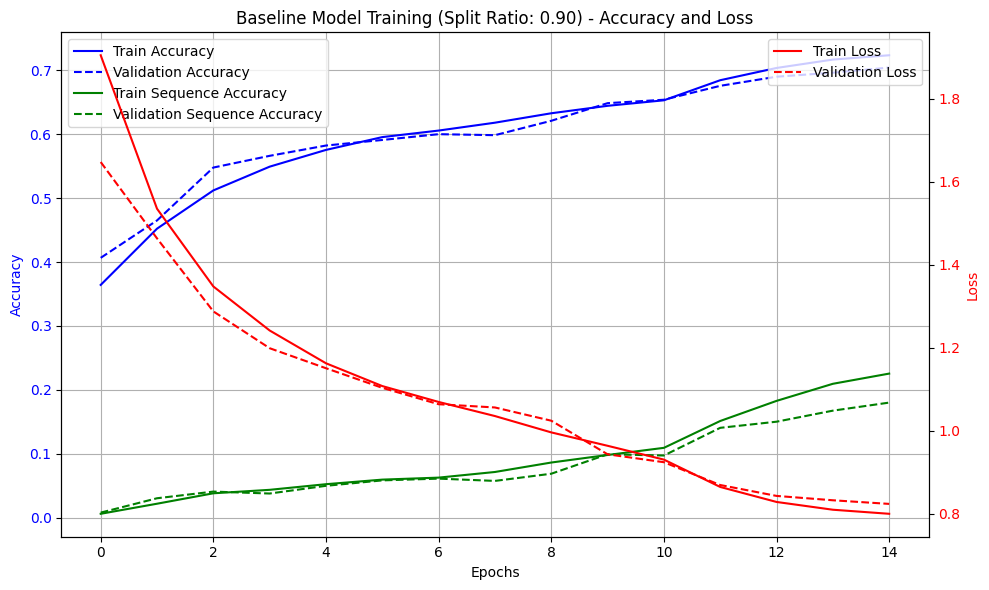

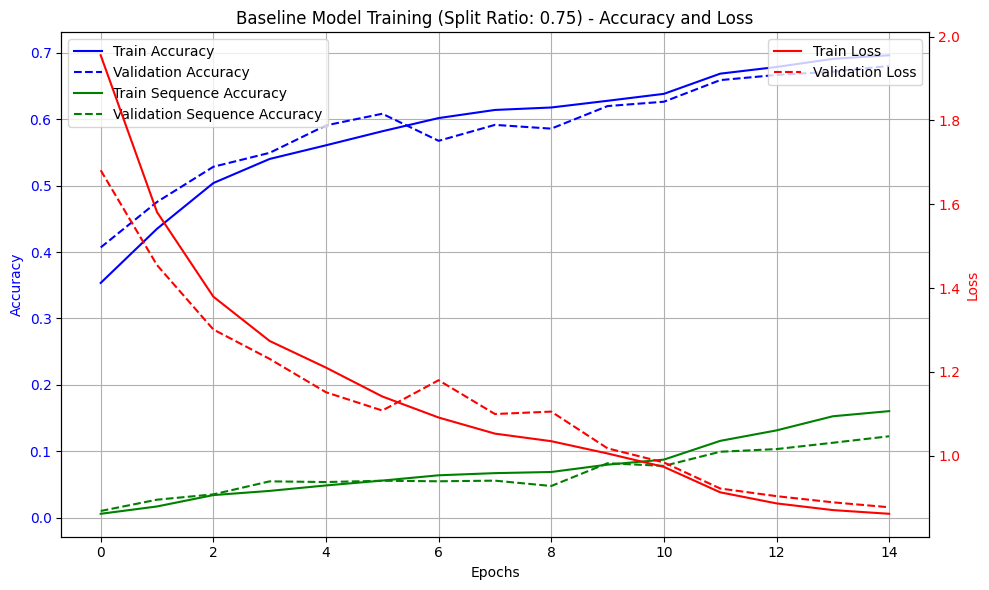

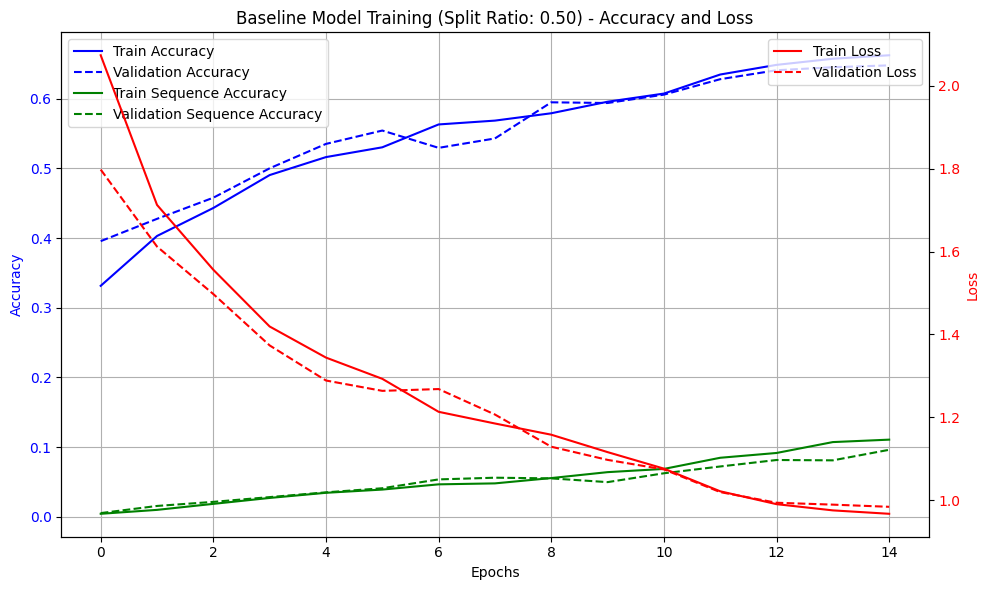

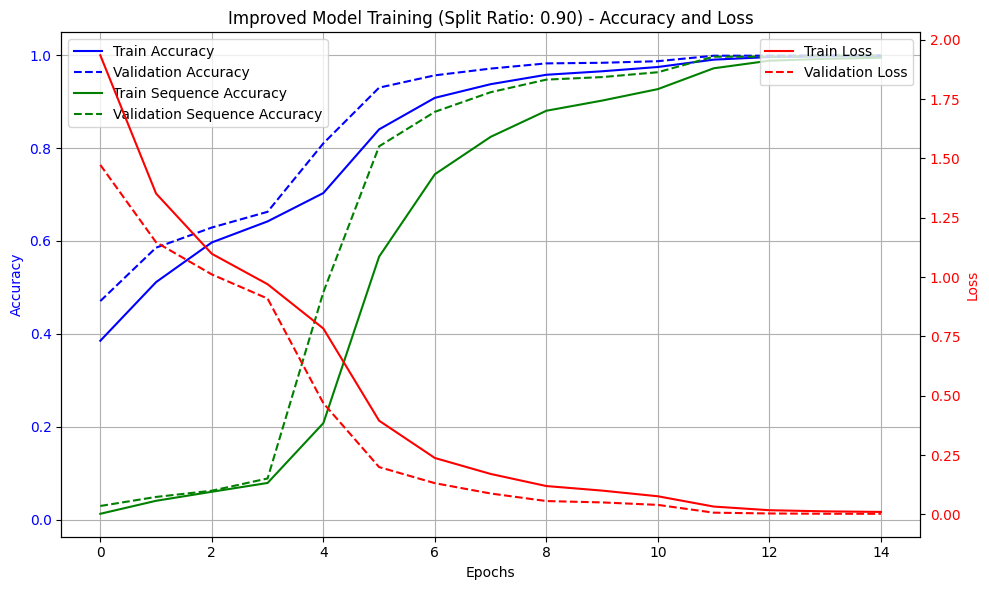

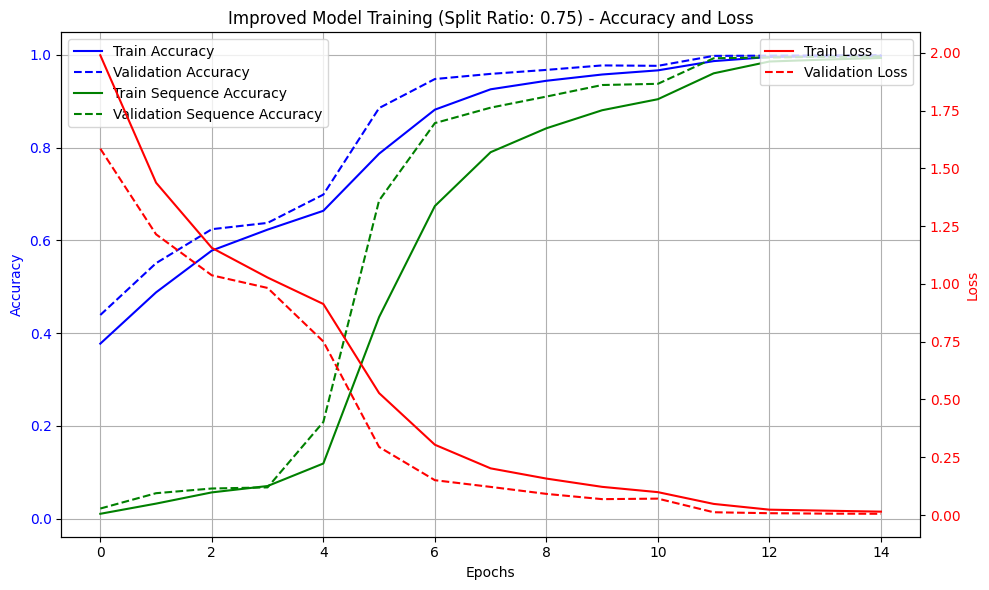

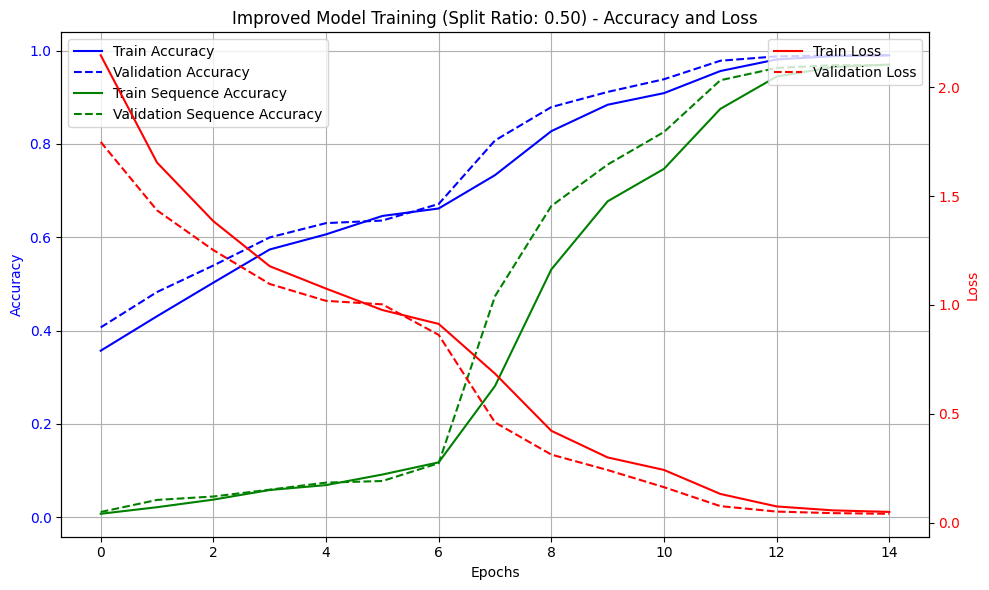

In [15]:
# Convert to DataFrames
baseline_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ["Model", "History"]} for r in baseline_results])
improved_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ["Model", "History"]} for r in improved_results])

# Plot Histories with Split Ratio in the Title
for result in baseline_results:
    split_ratio = result["Split Ratio"]
    plot_training_history_double_as(result["History"], title=f"Baseline Model Training (Split Ratio: {split_ratio:.2f})")

for result in improved_results:
    split_ratio = result["Split Ratio"]
    plot_training_history_double_as(result["History"], title=f"Improved Model Training (Split Ratio: {split_ratio:.2f})")

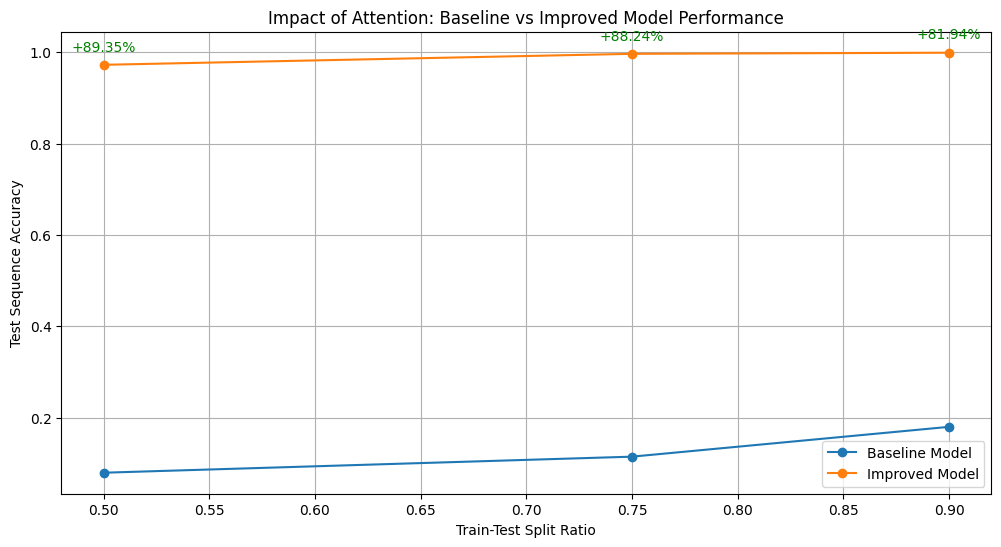

In [16]:
highlight_performance_trends(baseline_df, improved_df)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


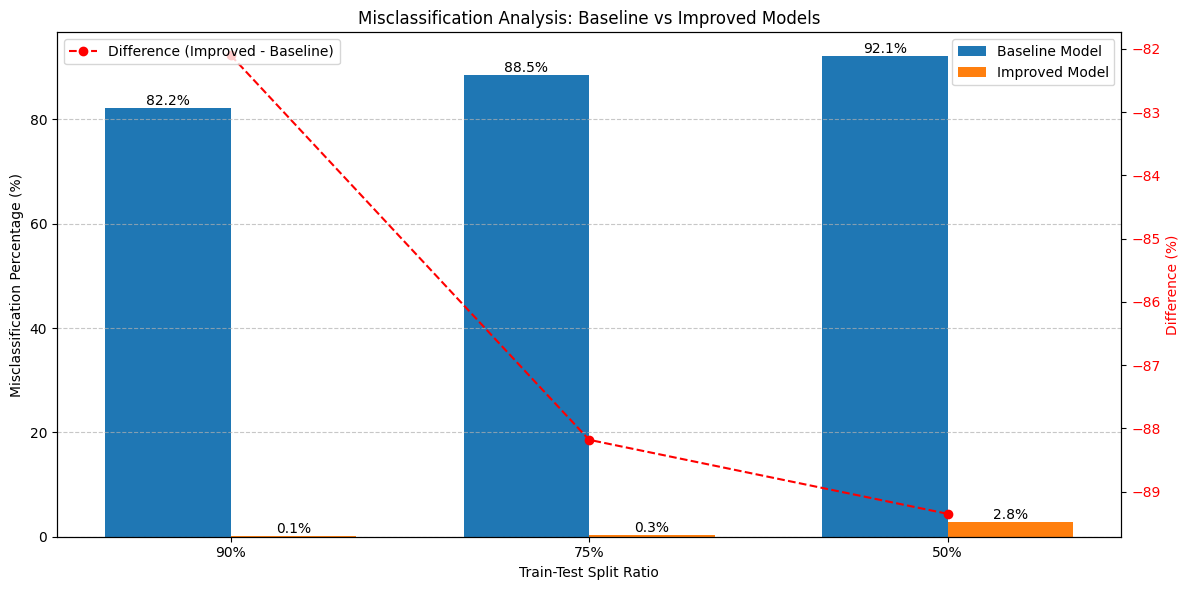

In [17]:
plot_misclassification_counts(baseline_results, improved_results)

In [18]:
baseline_df

,Split Ratio,Train Accuracy,Validation Accuracy,Train Sequence Accuracy,Validation Sequence Accuracy,Validation Loss,Test Loss,Test Accuracy,Test Sequence Accuracy,Test Data
0,0.90,0.723565,0.704352,0.225486,0.180099,0.823897,0.819138,0.708667,0.179563,"([[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], [..."
1,0.75,0.696555,0.680555,0.160406,0.122530,0.876918,0.879475,0.678667,0.114252,"([[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], [..."
2,0.50,0.662167,0.647667,0.110750,0.096191,0.984056,0.992433,0.645266,0.079073,"([[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], [..."


In [19]:
improved_df

,Split Ratio,Train Accuracy,Validation Accuracy,Train Sequence Accuracy,Validation Sequence Accuracy,Validation Loss,Test Loss,Test Accuracy,Test Sequence Accuracy,Test Data
0,0.90,0.998148,0.999815,0.994444,0.999452,0.002551,0.002103,0.999667,0.999008,"([[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], [..."
1,0.75,0.997639,0.998778,0.992935,0.996343,0.005561,0.005463,0.998733,0.996616,"([[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], [..."
2,0.50,0.990083,0.990000,0.970250,0.968750,0.040110,0.036502,0.990600,0.972544,"([[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], [..."


In [20]:
# Identify the best-performing model based on Sequence Accuracy
best_result = max(improved_results, key=lambda x: x["Test Sequence Accuracy"])
best_model = best_result["Model"]
X_test, y_test = best_result["Test Data"]

# Information about the best-performing model
print("Best-Performing Model Information:")
print(f"Split Ratio: {best_result['Split Ratio']:.2f}")
print(f"Test Sequence Accuracy: {best_result['Test Sequence Accuracy']:.4f}")
print(f"Validation Sequence Accuracy: {best_result['Validation Sequence Accuracy']:.4f}")
print(f"Test Accuracy: {best_result['Test Accuracy']:.4f}")
print(f"Validation Accuracy: {best_result['Validation Accuracy']:.4f}")
print(f"Validation Loss: {best_result['Validation Loss']:.4f}")
print(f"Test Loss: {best_result['Test Loss']:.4f}")

# Decode predictions for a subset of test samples
decoded_df = decode_predictions_to_df(best_model, X_test, y_test, num_samples=10)

# Perform misclassification analysis
all_results_df, misclassified_df = misclassification_analysis_to_df(best_model, X_test, y_test)

Best-Performing Model Information:
Split Ratio: 0.90
Test Sequence Accuracy: 0.9990
Validation Sequence Accuracy: 0.9995
Test Accuracy: 0.9997
Validation Accuracy: 0.9998
Validation Loss: 0.0026
Test Loss: 0.0021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [21]:
print("Decoded Predictions for First 10 Samples:")
decoded_df

Decoded Predictions for First 10 Samples:


,True Label,Predicted Label,Correct
0,78,78,True
1,-10,-10,True
2,77,77,True
3,62,62,True
4,120,120,True
5,-22,-22,True
6,91,91,True
7,16,16,True
8,13,13,True
9,-17,-17,True


In [22]:
print("\nSummary of Misclassified Samples:")
misclassified_df # None misclassified samples with best model


Summary of Misclassified Samples:


,True Label,Predicted Label,Correct
525,90,80,False
870,70,60,False



---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [23]:
def build_image2text_model():
    """
    Build a baseline Image-to-Text RNN model.
    """
    input_shape = (max_query_length, 28, 28, 1)
    inputs = Input(shape=input_shape)

    # TimeDistributed CNN to process each image
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)
    x = TimeDistributed(Dense(128, activation='relu'))(x)

    # Encoder LSTM
    encoder_outputs, state_h, state_c = LSTM(256, return_state=True)(x)

    # Repeat the encoded vector for the decoder
    decoder_inputs = RepeatVector(max_answer_length)(encoder_outputs)

    # Decoder LSTM
    decoder_outputs = LSTM(256, return_sequences=True)(decoder_inputs)

    # Output layer
    outputs = TimeDistributed(Dense(len(unique_characters), activation='softmax'))(decoder_outputs)

    # Build and compile the model
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()
    return model

In [24]:
def build_improved_image2text_model():
    """
    Build an improved Image-to-Text RNN model with attention and regularization.
    """
    input_shape = (max_query_length, 28, 28, 1)
    inputs = Input(shape=input_shape)

    # TimeDistributed CNN to process each image
    x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'))(inputs)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Dropout(0.3))(x)

    x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Dropout(0.3))(x)

    x = TimeDistributed(Flatten())(x)
    x = TimeDistributed(Dense(256, activation='relu'))(x)
    x = TimeDistributed(Dropout(0.3))(x)

    # Encoder LSTM
    encoder_outputs, state_h, state_c = LSTM(512, return_sequences=True, return_state=True)(x)
    encoder_outputs = Dropout(0.3)(encoder_outputs)
    encoder_outputs = LayerNormalization()(encoder_outputs)

    # Attention mechanism
    attention = Attention()([encoder_outputs, encoder_outputs])

    # Flatten attention output and pass through Dense layer
    decoder_input = Flatten()(attention)
    decoder_input = Dense(512, activation='relu')(decoder_input)
    decoder_input = Dropout(0.3)(decoder_input)

    # Repeat the vector for the decoder
    decoder_input = RepeatVector(max_answer_length)(decoder_input)

    # Decoder LSTM
    decoder_outputs = LSTM(512, return_sequences=True)(decoder_input)
    decoder_outputs = Dropout(0.3)(decoder_outputs)
    decoder_outputs = LayerNormalization()(decoder_outputs)

    # Output layer
    outputs = TimeDistributed(Dense(len(unique_characters), activation='softmax'))(decoder_outputs)

    # Build and compile the model (Keras)
    model = tf.keras.models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()
    return model

In [25]:
def train_image2text_model(model_builder, X_img, y_text_onehot, split_ratio=0.8, epochs=20, batch_size=64):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_img, y_text_onehot, test_size=1 - split_ratio, random_state=42
    )

    # Build the model
    model = model_builder()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return model, history, (X_test, y_test)

In [26]:
# Train the baseline model
baseline_model, baseline_history, (X_test_baseline, y_test_baseline) = train_image2text_model(
    build_image2text_model, X_img, y_text_onehot, split_ratio=0.8, epochs=20
)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 5, 28, 28, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 5, 28, 28, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 5, 14, 14, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 5, 6272)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 5, 128)              │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ [(None, 256), (None, 256),  │         394,240 │
│                                      │ (None, 256)]                │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_6 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 3, 13)               │           3,341 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,726,157 (6.58 MB)

 Trainable params: 1,726,157 (6.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3003 - loss: 2.1549 - val_accuracy: 0.3947 - val_loss: 1.7835
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4028 - loss: 1.7096 - val_accuracy: 0.4343 - val_loss: 1.5880
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4484 - loss: 1.5413 - val_accuracy: 0.4718 - val_loss: 1.4852
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4820 - loss: 1.4237 - val_accuracy: 0.4896 - val_loss: 1.4203
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5116 - loss: 1.3332 - val_accuracy: 0.5175 - val_loss: 1.3436
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5441 - loss: 1.2515 - val_accuracy: 0.5433 - val_loss: 1.2722
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5764 - loss: 1.1640 - val_accuracy: 0.5687 - val_loss: 1.2117
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5985 - loss: 1.1032 - val_accu

In [27]:
# Train the improved model
improved_model, improved_history, (X_test_improved, y_test_improved) = train_image2text_model(
    build_improved_image2text_model, X_img, y_text_onehot, split_ratio=0.8, epochs=20
)

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 5, 28, 28, 1)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_11       │ (None, 5, 28, 28, 64)  │            640 │ input_layer_7[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_12       │ (None, 5, 28, 28, 64)  │            256 │ time_distributed_11[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_13       │ (None, 5, 28, 28, 64)  │         36,928 │ time_distributed_12[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_14       │ (None, 5, 28, 28, 64)  │            256 │ time_distributed_13[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_15       │ (None, 5, 14, 14, 64)  │              0 │ time_distributed_14[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_16       │ (None, 5, 14, 14, 64)  │              0 │ time_distributed_15[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_17       │ (None, 5, 14, 14, 128) │         73,856 │ time_distributed_16[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_18       │ (None, 5, 14, 14, 128) │            512 │ time_distributed_17[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_19       │ (None, 5, 14, 14, 128) │        147,584 │ time_distributed_18[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_20       │ (None, 5, 14, 14, 128) │            512 │ time_distributed_19[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_21       │ (None, 5, 7, 7, 128)   │              0 │ time_distributed_20[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_22       │ (None, 5, 7, 7, 128)   │              0 │ time_distributed_21[0… │
│ (TimeDistributed)         │                        │                │                        │
├──────────────────────

 Total params: 6,860,493 (26.17 MB)

 Trainable params: 6,859,725 (26.17 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step - accuracy: 0.2748 - loss: 2.4439 - val_accuracy: 0.3955 - val_loss: 1.8379
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.3856 - loss: 1.9054 - val_accuracy: 0.4252 - val_loss: 1.6391
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.4266 - loss: 1.6583 - val_accuracy: 0.4692 - val_loss: 1.4983
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - accuracy: 0.4506 - loss: 1.5370 - val_accuracy: 0.5232 - val_loss: 1.3628
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.4889 - loss: 1.4153 - val_accuracy: 0.5322 - val_loss: 1.2849
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.5200 - loss: 1.3182 - val_accuracy: 0.5791 - val_loss: 1.1369
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.5611 - loss: 1.1679 - val_accuracy: 0.6663 - val_loss: 0.9254
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.6155 - loss: 1

In [28]:
def calculate_sequence_accuracy(y_true, y_pred):
    # Decode predictions and true labels
    y_true_decoded = np.argmax(y_true, axis=-1)
    y_pred_decoded = np.argmax(y_pred, axis=-1)

    # Compare sequences
    correct_sequences = np.all(y_true_decoded == y_pred_decoded, axis=1)
    sequence_accuracy = np.mean(correct_sequences)

    return sequence_accuracy

In [29]:
# Predict on test data for baseline model
y_pred_baseline = baseline_model.predict(X_test_baseline)
baseline_seq_accuracy = calculate_sequence_accuracy(y_test_baseline, y_pred_baseline)
print(f"Baseline Model Sequence Accuracy: {baseline_seq_accuracy:.4f}")

# Predict on test data for improved model
y_pred_improved = improved_model.predict(X_test_improved)
improved_seq_accuracy = calculate_sequence_accuracy(y_test_improved, y_pred_improved)
print(f"Improved Model Sequence Accuracy: {improved_seq_accuracy:.4f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Baseline Model Sequence Accuracy: 0.6930
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Improved Model Sequence Accuracy: 0.8800


In [30]:
# Select 5 random examples
num_examples = 5
indices = np.random.choice(len(X_test_improved), num_examples, replace=False)

# Get the selected samples
X_sample = X_test_improved[indices]
y_sample = y_test_improved[indices]

In [31]:
# Predict the answers
y_pred_sample = improved_model.predict(X_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [32]:
def decode_one_hot_sequences(one_hot_sequences, unique_characters):
    decoded_sequences = []
    for sequence in one_hot_sequences:
        indices = np.argmax(sequence, axis=1)
        chars = [unique_characters[idx] for idx in indices]
        decoded_sequence = ''.join(chars).strip()
        decoded_sequences.append(decoded_sequence)
    return decoded_sequences

In [33]:
# Decode the predictions
predicted_answers = decode_one_hot_sequences(y_pred_sample, unique_characters)

# Decode the true answers
true_answers = decode_one_hot_sequences(y_sample, unique_characters)

In [34]:
def display_predictions(X_samples, predicted_answers, true_answers):
    num_samples = len(X_samples)
    max_query_length = X_samples.shape[1]

    for i in range(num_samples):
        plt.figure(figsize=(7, 2))
        plt.suptitle(f"True Answer: {true_answers[i]}, Predicted Answer: {predicted_answers[i]}")
        for j in range(max_query_length):
            plt.subplot(1, max_query_length, j+1)
            plt.axis('off')
            img = X_samples[i][j].squeeze()
            plt.imshow(img, cmap='gray')
        plt.show()


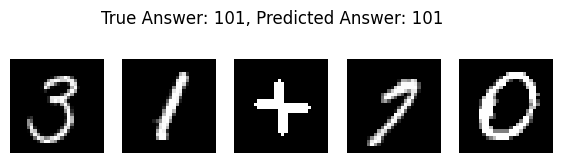

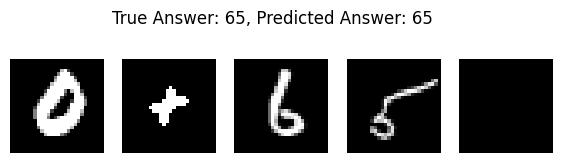

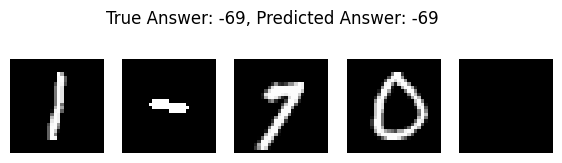

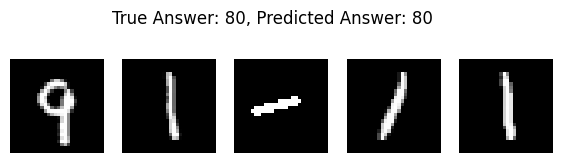

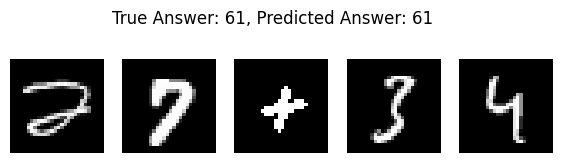

In [35]:
# Call the function
display_predictions(X_sample, predicted_answers, true_answers)

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [36]:
def build_text2image_model():
    """
    Build the original Text-to-Image RNN model.
    """
    # Input layer for text sequences
    input_shape = (max_query_length, len(unique_characters))
    inputs = Input(shape=input_shape)

    # Encoder LSTM
    encoder_outputs, state_h, state_c = LSTM(256, return_state=True)(inputs)
    encoder_states = [state_h, state_c]

    # Repeat the hidden state for each time step of the output sequence
    decoder_inputs = RepeatVector(max_answer_length)(state_h)

    # Decoder LSTM
    decoder_lstm = LSTM(256, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)

    # Dense layer to increase dimensionality
    decoder_dense = TimeDistributed(Dense(7 * 7 * 128, activation='relu'))
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = TimeDistributed(Reshape((7, 7, 128)))(decoder_outputs)

    # Upsampling to generate images
    decoder_outputs = TimeDistributed(
        Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')
    )(decoder_outputs)
    decoder_outputs = TimeDistributed(BatchNormalization())(decoder_outputs)
    decoder_outputs = TimeDistributed(
        Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')
    )(decoder_outputs)
    decoder_outputs = TimeDistributed(BatchNormalization())(decoder_outputs)
    decoder_outputs = TimeDistributed(
        Conv2DTranspose(1, (3, 3), padding='same', activation='tanh')
    )(decoder_outputs)

    # Build and compile the model
    model = Model(inputs, decoder_outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    model.summary()
    return model

In [37]:
def build_text2image_model_modified():
    """
    Build a modified Text-to-Image RNN model with additional LSTM layers in the encoder.
    """
    # Input layer for text sequences
    input_shape = (max_query_length, len(unique_characters))
    inputs = Input(shape=input_shape)

    # Encoder LSTM layers
    # First LSTM layer with return_sequences=True
    encoder_outputs = LSTM(256, return_sequences=True)(inputs)

    # Second LSTM layer
    encoder_outputs, state_h, state_c = LSTM(256, return_state=True)(encoder_outputs)
    encoder_states = [state_h, state_c]

    # Repeat the hidden state for each time step of the output sequence
    decoder_inputs = RepeatVector(max_answer_length)(state_h)

    # Decoder LSTM
    decoder_lstm = LSTM(256, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)

    # Dense layer to increase dimensionality
    decoder_dense = TimeDistributed(Dense(7 * 7 * 128, activation='relu'))
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = TimeDistributed(Reshape((7, 7, 128)))(decoder_outputs)

    # Upsampling to generate images
    decoder_outputs = TimeDistributed(
        Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')
    )(decoder_outputs)
    decoder_outputs = TimeDistributed(BatchNormalization())(decoder_outputs)
    decoder_outputs = TimeDistributed(
        Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')
    )(decoder_outputs)
    decoder_outputs = TimeDistributed(BatchNormalization())(decoder_outputs)
    decoder_outputs = TimeDistributed(
        Conv2DTranspose(1, (3, 3), padding='same', activation='tanh')
    )(decoder_outputs)

    # Build and compile the model
    model = Model(inputs, decoder_outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    model.summary()
    return model

In [38]:
def train_text2image_model(model_builder, X_text_onehot, y_img, epochs=20, batch_size=64):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_text_onehot, y_img, test_size=0.2, random_state=42
    )

    # Build the model
    model = model_builder()

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return model, history, (X_test, y_test)

In [39]:
# Train the original Text-to-Image model
original_text2image_model, original_history, (X_test_original, y_test_original) = train_text2image_model(
    build_text2image_model, X_text_onehot, y_img, epochs=20, batch_size=64
)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 5, 13)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_22 (LSTM)            │ [(None, 256), (None,   │        276,480 │ input_layer_8[0][0]    │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_8           │ (None, 3, 256)         │              0 │ lstm_22[0][1]          │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_23 (LSTM)            │ (None, 3, 256)         │        525,312 │ repeat_vector_8[0][0], │
│                           │                        │                │ lstm_22[0][1],         │
│                           │                        │                │ lstm_22[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_27       │ (None, 3, 6272)        │      1,611,904 │ lstm_23[0][0]          │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_28       │ (None, 3, 7, 7, 128)   │              0 │ time_distributed_27[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_29       │ (None, 3, 14, 14, 128) │        147,584 │ time_distributed_28[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_30       │ (None, 3, 14, 14, 128) │            512 │ time_distributed_29[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_31       │ (None, 3, 28, 28, 64)  │         73,792 │ time_distributed_30[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_32       │ (None, 3, 28, 28, 64)  │            256 │ time_distributed_31[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_33       │ (None, 3, 28, 28, 1)   │            577 │ time_distributed_32[0… │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,636,417 (10.06 MB)

 Trainable params: 2,636,033 (10.06 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 0.0594 - val_loss: 0.0523
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - loss: 0.0498 - val_loss: 0.0482
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0481 - val_loss: 0.0473
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.0478 - val_loss: 0.0479
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0471 - val_loss: 0.0471
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 0.0468 - val_loss: 0.0466
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.0464 - val_loss: 0.0462
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.0463 - val_loss: 0.0462
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0460 - val_loss: 0.0458
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0458 - val_loss: 0.0455
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0454 - val_loss: 0.0452
Epoch 12/20
250/250 ━━━━━━━━━━

In [40]:
# Train the modified Text-to-Image model
modified_text2image_model, modified_history, (X_test_modified, y_test_modified) = train_text2image_model(
    build_text2image_model_modified, X_text_onehot, y_img, epochs=20, batch_size=64
)

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 5, 13)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_24 (LSTM)            │ (None, 5, 256)         │        276,480 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_25 (LSTM)            │ [(None, 256), (None,   │        525,312 │ lstm_24[0][0]          │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_9           │ (None, 3, 256)         │              0 │ lstm_25[0][1]          │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_26 (LSTM)            │ (None, 3, 256)         │        525,312 │ repeat_vector_9[0][0], │
│                           │                        │                │ lstm_25[0][1],         │
│                           │                        │                │ lstm_25[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_34       │ (None, 3, 6272)        │      1,611,904 │ lstm_26[0][0]          │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_35       │ (None, 3, 7, 7, 128)   │              0 │ time_distributed_34[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_36       │ (None, 3, 14, 14, 128) │        147,584 │ time_distributed_35[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_37       │ (None, 3, 14, 14, 128) │            512 │ time_distributed_36[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_38       │ (None, 3, 28, 28, 64)  │         73,792 │ time_distributed_37[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_39       │ (None, 3, 28, 28, 64)  │            256 │ time_distributed_38[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_40       │ (None, 3, 28, 28, 1)   │            577 │ time_distributed_39[0… │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,161,729 (12.06 MB)

 Trainable params: 3,161,345 (12.06 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - loss: 0.0558 - val_loss: 0.0521
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.0494 - val_loss: 0.0485
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.0481 - val_loss: 0.0477
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 0.0474 - val_loss: 0.0470
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 0.0471 - val_loss: 0.0468
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.0467 - val_loss: 0.0467
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.0464 - val_loss: 0.0463
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.0461 - val_loss: 0.0460
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0461 - val_loss: 0.0457
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.0458 - val_loss: 0.0456
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.0456 - val_loss: 0.0459
Epoch 12/20
250/250 ━━━━━━━━━━

In [41]:
# Number of samples to evaluate
num_samples = 5

# Randomly select samples from the test set
indices = np.random.choice(len(X_test_original), num_samples, replace=False)
X_sample_original = X_test_original[indices]
y_true_sample_original = y_test_original[indices]

X_sample_modified = X_test_modified[indices]
y_true_sample_modified = y_test_modified[indices]

In [42]:
# Generate images using the original model
y_pred_sample_original = original_text2image_model.predict(X_sample_original)

# Generate images using the modified model
y_pred_sample_modified = modified_text2image_model.predict(X_sample_modified)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


In [43]:
def display_generated_images(X_samples, y_true_samples, y_pred_samples, model_name):
    for i in range(len(X_samples)):
        # Decode the input text
        input_indices = np.argmax(X_samples[i], axis=1)
        input_chars = [unique_characters[idx] for idx in input_indices]
        input_text = ''.join(input_chars).strip()

        # Prepare true and predicted images
        true_images = (y_true_samples[i] + 1) / 2.0  # Scale back to [0, 1]
        pred_images = (y_pred_samples[i] + 1) / 2.0  # Scale back to [0, 1]

        num_digits = true_images.shape[0]
        plt.figure(figsize=(6, 2))

        for j in range(num_digits):
            # True images
            plt.subplot(2, num_digits, j + 1)
            plt.axis('off')
            plt.imshow(true_images[j].squeeze(), cmap='gray')
            if j == 0:
                plt.title(f'True Images\nInput: {input_text}')

            # Predicted images
            plt.subplot(2, num_digits, j + num_digits + 1)
            plt.axis('off')
            plt.imshow(pred_images[j].squeeze(), cmap='gray')
            if j == 0:
                plt.title(f'{model_name} Generated Images')

        plt.show()


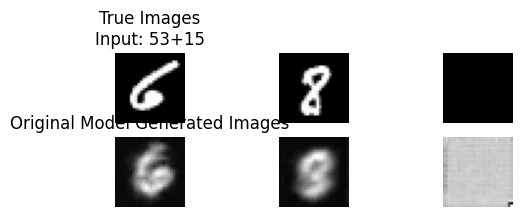

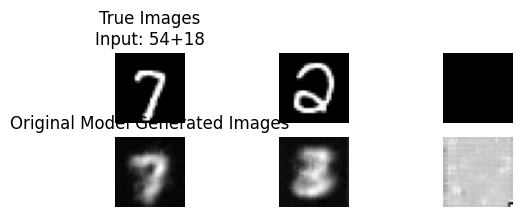

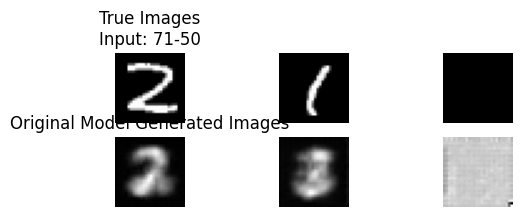

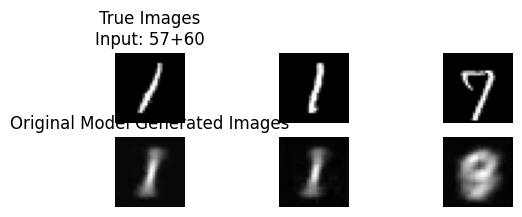

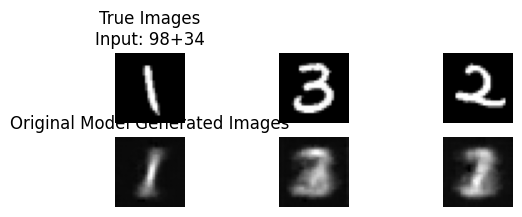

In [44]:
display_generated_images(X_sample_original, y_true_sample_original, y_pred_sample_original, model_name='Original Model')

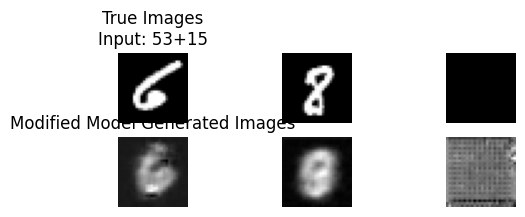

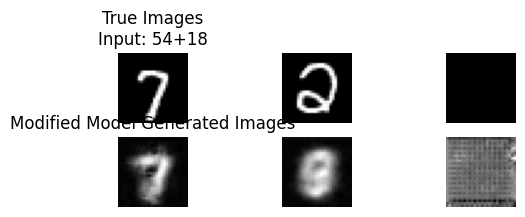

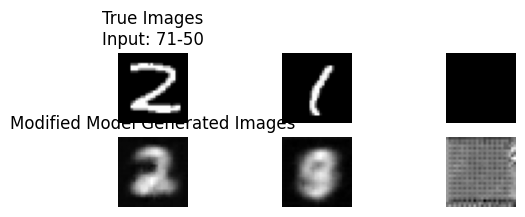

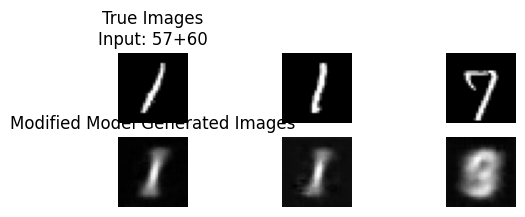

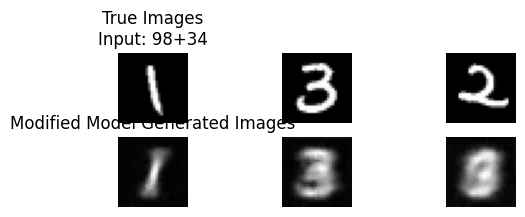

In [45]:
display_generated_images(X_sample_modified, y_true_sample_modified, y_pred_sample_modified, model_name='Modified Model')